In [1]:
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import scipy.signal as signal
import pandas as pd
import matplotlib.dates as dates
import obspy.signal.trigger as trigger
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import config

def import_data(day, starttime, endtime):
    daypaths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day)
    starttime = obspy.UTCDateTime(starttime)
    endtime = obspy.UTCDateTime(endtime)
    data = load.import_corrected_data_for_single_day(daypaths)
    data.trim(starttime=starttime, endtime=endtime)
    return data

In [2]:
day141 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')

In [3]:
day188 = import_data(day=188, starttime='2019-07-07T08:40:00.0Z', endtime='2019-07-07T10:15:00.0Z')

In [4]:
day197 = import_data(day=197, starttime='2019-07-16T21:45:00.0Z', endtime='2019-07-17T00:00:00.337999Z')

In [5]:
day211 = import_data(day=211, starttime='2019-07-30T22:30:05.142999Z', endtime='2019-07-30T23:07:04.430999Z')

In [6]:
day141[0].stats

         network: 7F
         station: A00
        location: 01
         channel: GDH
       starttime: 2019-05-21T07:00:00.000000Z
         endtime: 2019-05-21T09:00:00.000000Z
   sampling_rate: 1000.0
           delta: 0.001
            npts: 7200001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 14851, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 60829696})
      processing: ['ObsPy 1.3.0: trim(endtime=UTCDateTime(2019, 5, 21, 9, 0)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2019, 5, 21, 7, 0))']

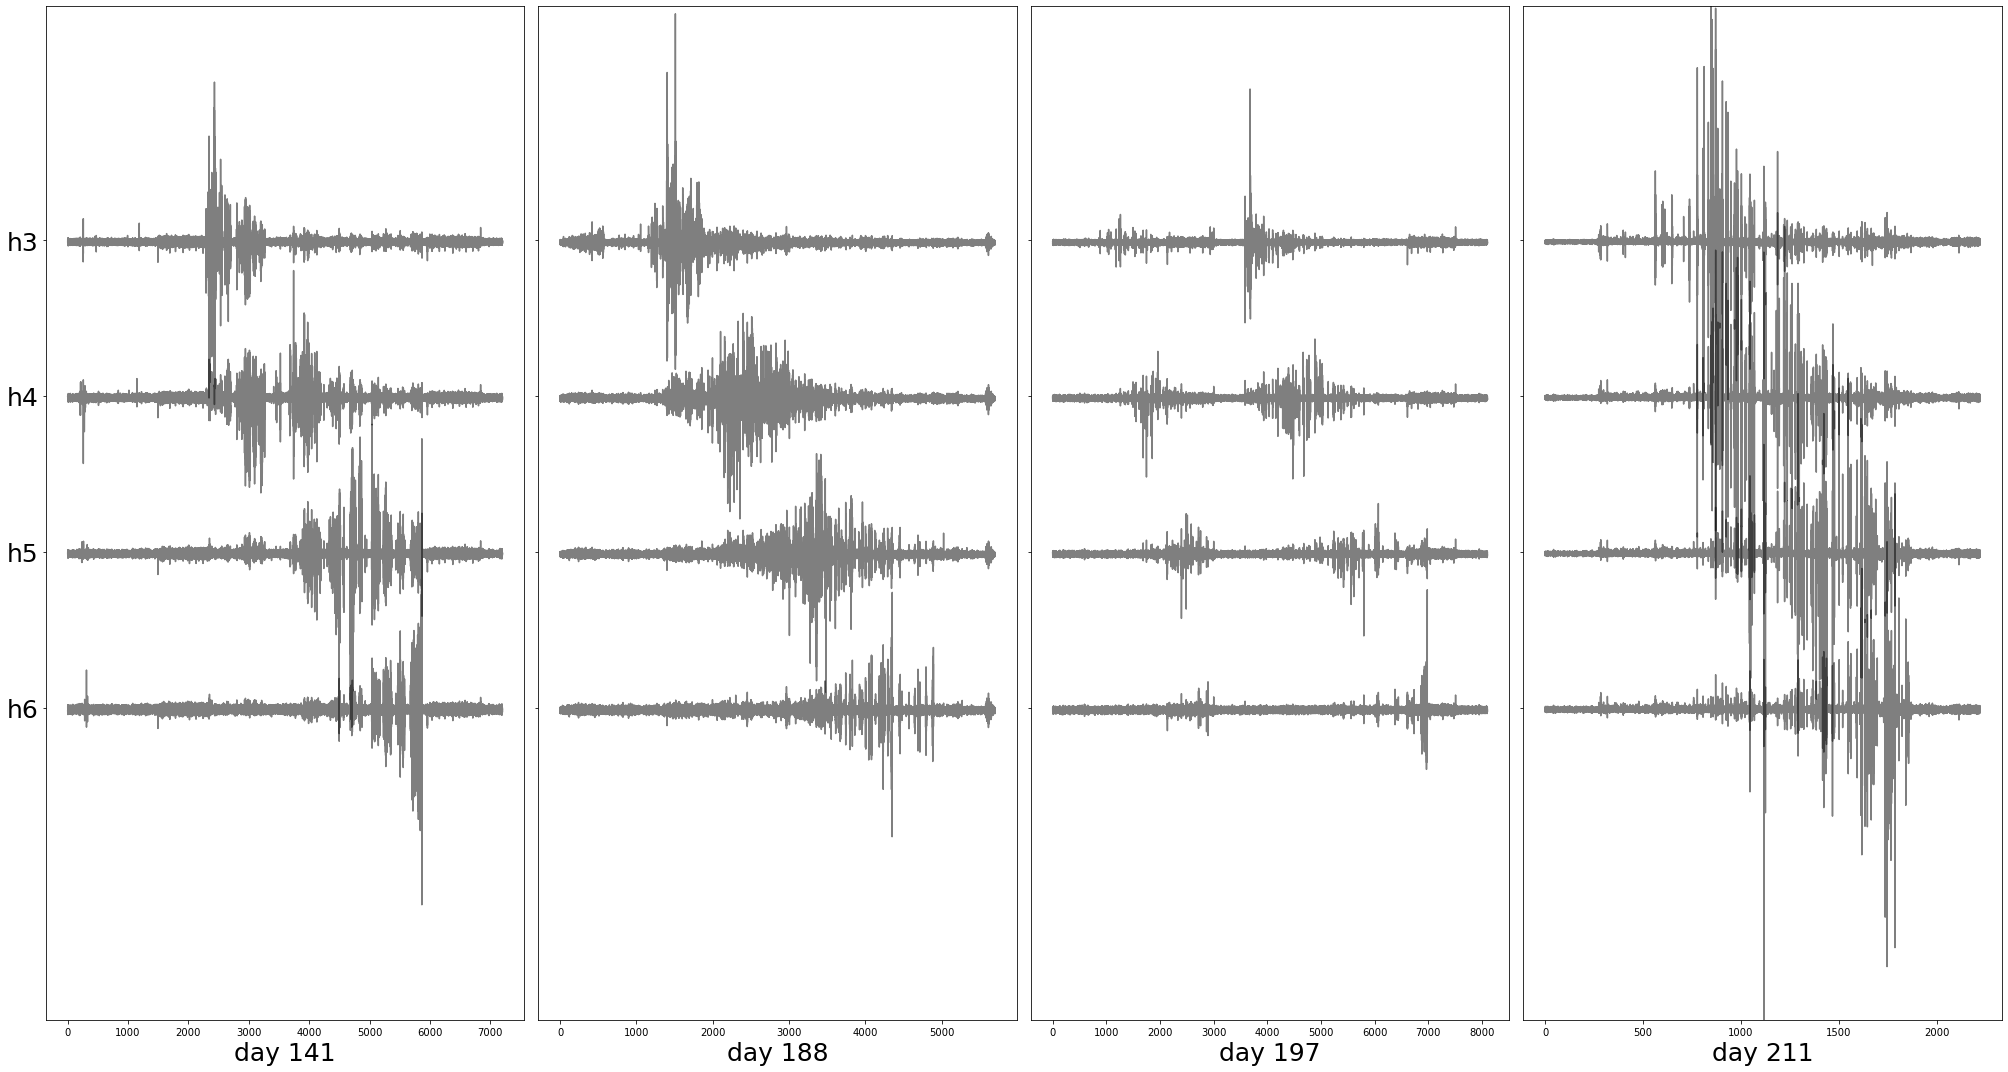

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(7*4, 15), sharey=True)

def plot_waveform(ax, stream, day):
    times = [tr.times() for tr in stream][2:]
    data = [tr.data for tr in stream][2:]
    n = 0
    for t, d in zip(times, data):
        ax.plot(t, d - n * 10, color='black', alpha=0.5)
        n+=1
        
    ax.set_xlabel('day ' + str(day), fontsize=25)

plot_waveform(ax=ax[0], stream=day141, day=141)
plot_waveform(ax=ax[1], stream=day188, day=188)
plot_waveform(ax=ax[2], stream=day197, day=197)
plot_waveform(ax=ax[3], stream=day211, day=211)

ax[0].set_ylim(-50, 15)
ax[0].set_yticks([0, -10, -20, -30])
ax[0].set_yticklabels(['h3', 'h4', 'h5', 'h6'], fontsize=25)

plt.tight_layout()

fig.savefig('figures/raw_waveforms.pdf', bbox_inches='tight')

In [8]:
import matplotlib.dates as dates

def import_catalog(file):
    df = pd.read_csv(file)
    df.sort_values(by='first_arrival', inplace=True)
    df['arrival_datetime'] = df.arrival_time.apply(dates.num2date)
    return df

def plot_depths(df, cmap, day):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df.arrival_datetime, df.depth, marker='.', linewidth=0, c=df.first_hydrophone, cmap=cmap)
    ax.set_ylabel('day '+str(day), fontsize=25)
    ax.set_ylim(400, 50)
    # ax.text(s='N_events={}'.format(df.shape[0]), x=df.arrival_time[50], y=375, fontsize=25)
    return fig, ax

def plot_radius(df, cmap, day):
    x = df.first_arrival.values
    y = np.abs(df.radius.values)
    c = df.depth.values
    
    fig, ax = plt.subplots(figsize=(15, 5))
    cbar = ax.scatter(x, y, marker='.', c=c, vmin=150, vmax=400, cmap=cmap)
    ax.set_xticks([])
    ax.set_ylim(-10, 60)
    fig.colorbar(cbar, label='depth (m)')
    ax.set_xlabel('time ---->', fontsize=15)
    ax.set_ylabel('radius (m)', fontsize=15)
    return fig, ax

In [9]:
df141 = import_catalog(file='141precision.csv')
df188 = import_catalog(file='188precision.csv')
df197 = import_catalog(file='197precision.csv')
df211 = import_catalog(file='211precision.csv')

number of raw events: 325
number of events after max amplitude removal: 260
fraction removed: 0.19999999999999996


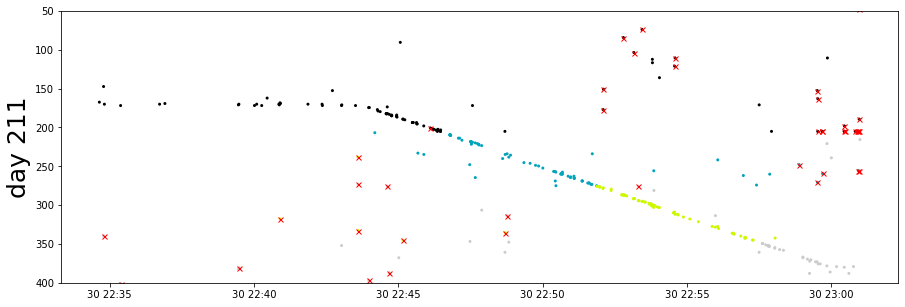

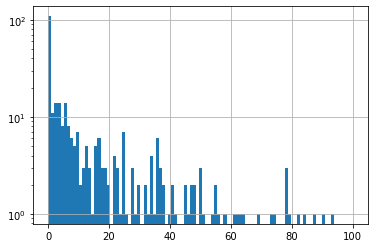

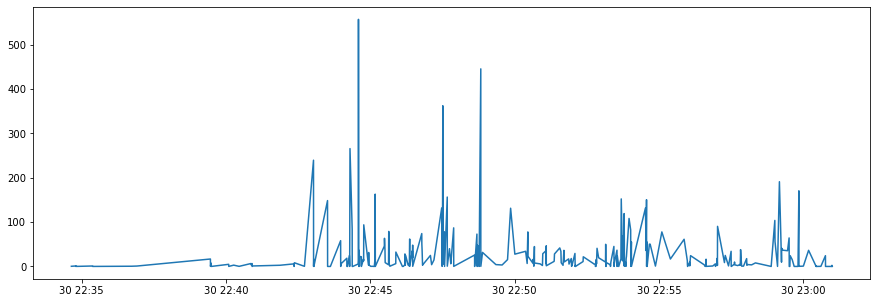

In [10]:
# The detection algorithm doesn't work for events with maximum amplitude <0.1, therefore it is likely these events are false positives and need to be removed. This can be demonstrated below.

data = df211.copy()
data_filter = data[data.max_amp > 0.1].copy()
filtered_events = data.drop(data_filter.index)

fig, ax = plot_depths(data, cmap='nipy_spectral', day=211)
ax.plot(filtered_events.arrival_datetime, filtered_events.depth, marker='x', color='red', markersize=5, linewidth=0)
print('number of raw events:', data.shape[0])
print('number of events after max amplitude removal:', data_filter.shape[0])
print('fraction removed: {}'.format(1-data_filter.shape[0]/data.shape[0]))
# ax.text(s='fraction of events left: {}%'.format(round(data.shape[0]/data_filter.shape[0],2))
       # ,x=data.arrival_datetime[50], y=350)

fig, ax = plt.subplots()
data.max_amp.hist(ax=ax, bins=np.linspace(0, 100, 100), log=True)
data.max_amp.sort_values().tail()

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(data.arrival_datetime, data.max_amp)

In [11]:
# removing the events with maximum amplitude <0.1 since they are false positives

df141 = df141[df141.max_amp > 0.1].copy()
df188 = df188[df188.max_amp > 0.1].copy()
df197 = df197[df197.max_amp > 0.1].copy()
df211 = df211[df211.max_amp > 0.1].copy()

In [12]:
# there is data to remove per the below evidence

# there are no events at depths of approx 350m before 09:20:00 on teh waveform data
# %matplotlib widget
# fig, ax = plt.subplots(figsize=(15, 5))
# starttime = obspy.UTCDateTime('2019-07-07T09:03:00')
# endtime = obspy.UTCDateTime('2019-07-07T09:19:00')
# plot_waveform(ax=ax, stream=day188.slice(starttime, endtime), day=188)

# x = df188.arrival_datetime
# y = df188.arrival_datetime.diff().apply(lambda t: t.total_seconds())
# fig, ax = plt.subplots(figsize=(15, 5))
# ax.plot(x, y)
# ax.set_ylim(0, 50)

# fig, ax = plt.subplots()
# y.hist(ax=ax, bins=np.linspace(0, 1, 100))

# fig, ax = plot_depths(df188, cmap='nipy_spectral', day=188)

# zeros = df188.loc[y[y<0.001].index]
# ax.plot(zeros.arrival_datetime, zeros.depth, marker='x', color='red', linewidth=0)

In [13]:
# remove spurious deep detections in day 188
# df188.drop(df188[df188.first_hydrophone.isin([4, 5]) & df188.arrival_datetime.between('2019-07-07 08:00:00', '2019-07-07 09:20:00')].index, inplace=True)

In [14]:
# event rates

# df188.arrival_datetime.diff().apply(lambda t: t.total_seconds()).hist(bins=np.linspace(0, 10, 100))

In [15]:
from event_pipeline import Event
event_id = 1251
paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=141)
waveforms = load.import_corrected_data_for_single_day(paths=paths)
e = Event(id=event_id, starttime=df141.arrival_time.iloc[event_id], init_first_hphone=df141.first_hydrophone, waveforms=waveforms)
# e.aics
print('loaded event {} successfully.'.format(event_id))

loaded event 1251 successfully.


/home/john/research/borehole_proj2/event_pipeline.py:197: RuntimeWarning: invalid value encountered in sqrt
  self.radius =  np.sqrt(vrock**2 * dt**2 - dz**2)


0:00:00.302000
big arrival start time 0:00:00.200000
event depth 330.125 -90.125
arrival hydrophone 5
origin time: -0.016


[18037.35004556713,
 18037.35004556713,
 18037.35004556713,
 18037.35004556713,
 18037.350042118054,
 18037.350042314814]

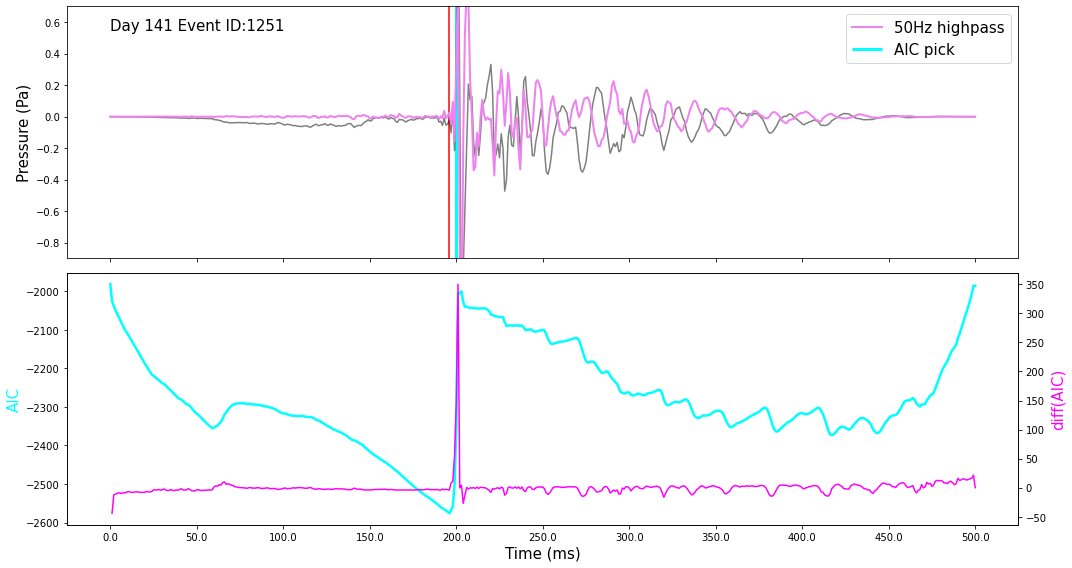

In [16]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

t_labels = e.stream[4].times() * 1e3 # milliseconds
times = e.stream[4].times('matplotlib')

ax.plot(times, e.stream[4].data, color='black', alpha=0.5)

st = e.stream.copy()
st.filter(type='highpass', freq=50)
ax.plot(times, st[4].data, color='violet', label='50Hz highpass', linewidth=2)

ax.vlines(x=e.aic_t[4], ymin=-0.9, ymax=0.7, color='cyan', linewidth=3, label='AIC pick')
ax.set_ylim(-0.9, 0.7)
ax.legend(fontsize=15)
ax.set_ylabel('Pressure (Pa)', fontsize=15)
ax.text(s='Day 141 Event ID:{}'.format(event_id), fontsize=15, x=times[0], y=0.55)

ax2.plot(times, e.aics[4], color='cyan', linewidth=2.5)

ax2.set_xticks(times[::50])
ax2.set_xticklabels(t_labels[::50])
ax2.set_xlabel('Time (ms)', fontsize=15)
ax2.set_ylabel('AIC', fontsize=15, color='cyan')

ax3 = ax2.twinx()
ax3.plot(times[1:], np.diff(e.aics[4]), color='magenta')
ax3.set_ylabel('diff(AIC)', fontsize=15, color='magenta')
# ax2.fill_between([times.min(), times[100]], y1=-2800, y2=-2100, color='black', alpha=0.15, zorder=20)

fig.tight_layout()
# np.isclose(e.aic_t[4], e.stream[4].times('matplotlib'))
# e.stream.plot()

# fig.savefig('figures/example_detections.pdf', bbox_inches='tight')
pt = dates.date2num(e.parrival)
print(dates.num2date(e.aic_t[0]) - e.parrival)
ax.vlines(x=pt, ymin=-0.9, ymax=0.7, color='red')
print('big arrival start time', dates.num2date(e.aic_t[4]) - dates.num2date(e.stream[0].times('matplotlib')[0]))
print('event depth', e.depth, 240-e.depth)
print('arrival hydrophone', e.first_hydrophone_id+1)
print('origin time:', (dates.num2date(e.aic_t[4]) - e.parrival).total_seconds() - 35/1750)
ot = (dates.num2date(e.aic_t[4]) - e.parrival).total_seconds() - 35/1750
# ax.vlines(x=ot, ymin=-0.9, ymax=0.7, color='limegreen')
# dates.num2date(e.stream[0].times('matplotlib')[0])
35./0.080
e.aic_t

#########################
# step 1: estimate depth
# step 2: assume r=0 get origin time
# step 3: take pick for initial phase, calculate propagation velocity

# reoccurence interval between swarms
# cumulative event/time plot
# are there depth patches where there are no events across each swarms?
# what about the downward migrating swarm in BA1B?
# stop assuming geology/rheology is the same between B and A

In [17]:
# ev_d = df141.sort_values(by='depth')[['depth']].copy()
# # ev_d.hist(bins=np.linspace(150, 400, (400-150)//1))

# fig, ax = plt.subplots(1, 4, figsize=(5*4, 15))
# ax=ax[0]
# ax.hist(ev_d, bins=np.linspace(150, 400, (400-150)//2), orientation='horizontal', zorder=0, color='black', alpha=0.15)

# ax2 = ax.twiny()
# ax2.scatter(x=df141['arrival_datetime'], y=df141['depth'], c=df141['depth']
#            ,cmap='nipy_spectral')
# # df141.plot.scatter(x='arrival_datetime', y='depth', c='depth'
# #                   ,cmap='nipy_spectral', ax=ax2)

# ax.set_ylim(400, 150)

# ''
# def plot_hydrophone_depth_horizontal_line(hid):
#     depth = config.hydrophone_metadata_141[hid]['depth']
#     ax.hlines(y=depth, xmin=0, xmax=70, linestyle='--', color='black')
# # config.hydrophone_metadata_141

# # ax.plot()
# plot_hydrophone_depth_horizontal_line('h3')
# plot_hydrophone_depth_horizontal_line('h4')
# plot_hydrophone_depth_horizontal_line('h5')
# plot_hydrophone_depth_horizontal_line('h6')
# ax.set_xlim(0, 70)
# fig.tight_layout()

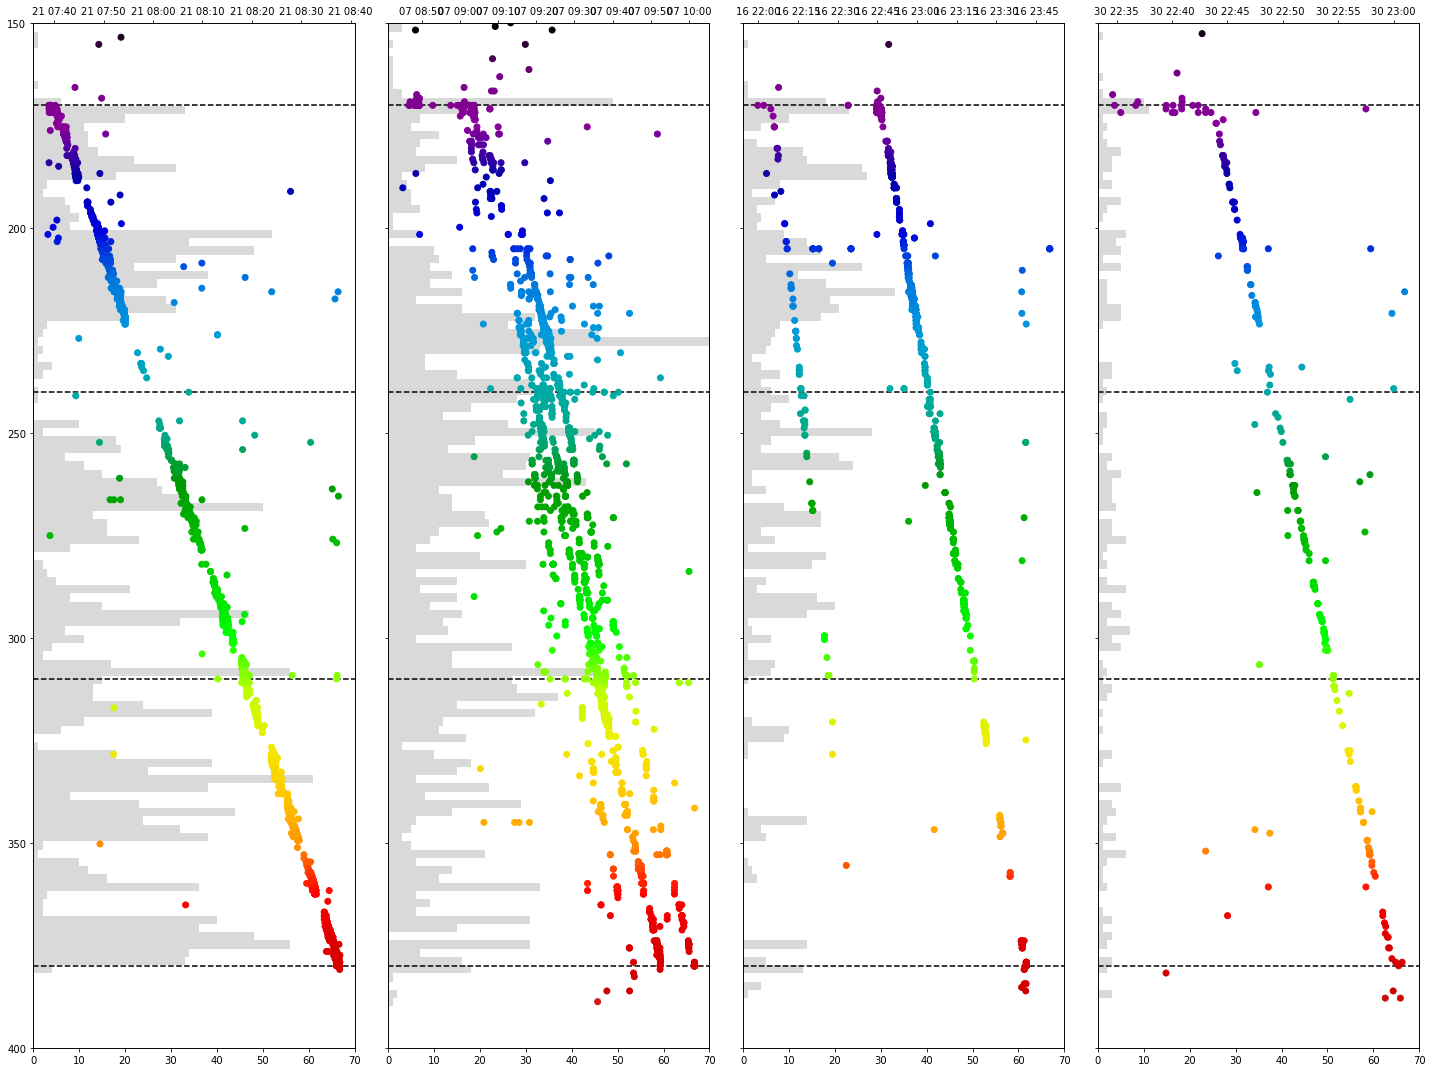

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(5*4, 15), sharey=True, sharex=True)

def plot_hist_scatter(day, ax=ax):
    def plot_hydrophone_depth_horizontal_line(hid):
        depth = config.hydrophone_metadata_141[hid]['depth']
        ax.hlines(y=depth, xmin=0, xmax=70, linestyle='--', color='black')

    ev_d = day.sort_values(by='depth')[['depth']].copy()
    ax.hist(ev_d, bins=np.linspace(150, 400, (400-150)//2), orientation='horizontal', zorder=0, color='black', alpha=0.15)
    ax2 = ax.twiny()
    ax2.scatter(x=day['arrival_datetime'], y=day['depth'], c=day['depth']
           ,cmap='nipy_spectral', vmin=150, vmax=400)
    plot_hydrophone_depth_horizontal_line('h3')
    plot_hydrophone_depth_horizontal_line('h4')
    plot_hydrophone_depth_horizontal_line('h5')
    plot_hydrophone_depth_horizontal_line('h6')
    
plot_hist_scatter(day=df141, ax=ax[0])
plot_hist_scatter(day=df188, ax=ax[1])
plot_hist_scatter(day=df197, ax=ax[2])
plot_hist_scatter(day=df211, ax=ax[3])

ax[0].set_ylim(400, 150)
ax[0].set_xlim(0, 70)
fig.tight_layout()

Text(0, 0.5, 'Event Count (normalized cnt/max)')

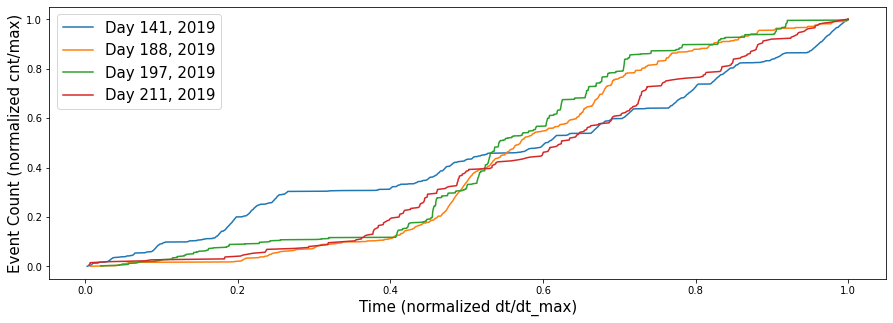

In [305]:
fig, ax = plt.subplots(figsize=(15, 5))
def make_cumcurve(df, label):
    data = df[['arrival_datetime']].copy()
    data['dt'] = data['arrival_datetime'].diff().apply(lambda t: t.total_seconds()).cumsum()
    # data['dt'] = data['dt']/data['dt'].max()
    data['ones'] = 1
    data['ones'] = data['ones'].cumsum()
    data['ones'] = data['ones']/data['ones'].max()
    # data.set_index('dt', inplace=True)
    ax.plot(data['dt']/data['dt'].max(), data.ones, label=label)

make_cumcurve(df141, label='Day 141, 2019')
make_cumcurve(df188, label='Day 188, 2019')
make_cumcurve(df197, label='Day 197, 2019')
make_cumcurve(df211, label='Day 211, 2019')
ax.legend(fontsize=15)
ax.set_xlabel('Time (normalized dt/dt_max)', fontsize=15)
ax.set_ylabel('Event Count (normalized cnt/max)', fontsize=15)

In [21]:
# import matplotlib.pyplot as plt
# import numpy as np
# import datetime as dt

# # Generate some random data for the scatter plot
# x = [dt.datetime(2022, 1, 1) + dt.timedelta(days=i) for i in range(100)]
# y = np.random.normal(0, 1, 100)

# # Create the figure and axis objects
# fig, ax = plt.subplots()

# # Create a histogram on the y-axis
# ax.hist(y, orientation='horizontal')

# # Create a scatter plot on the x and y axes
# ax.scatter(x, y)

# # Set the x and y axis labels and plot title
# ax.set_xlabel('Date')
# ax.set_ylabel('Y values')
# ax.set_title('Histogram and Scatter Plot')

# # Format the x axis as dates
# date_fmt = '%m-%d-%Y'
# import matplotlib as mpl
# date_formatter = mpl.dates.DateFormatter(date_fmt)
# ax.xaxis.set_major_formatter(date_formatter)
# fig.autofmt_xdate()

# # Display the plot
# plt.show()

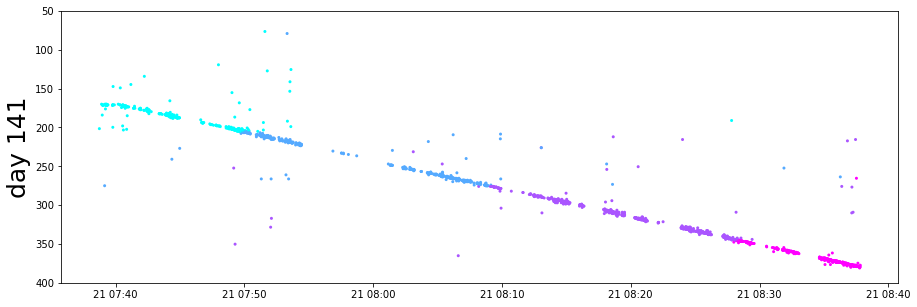

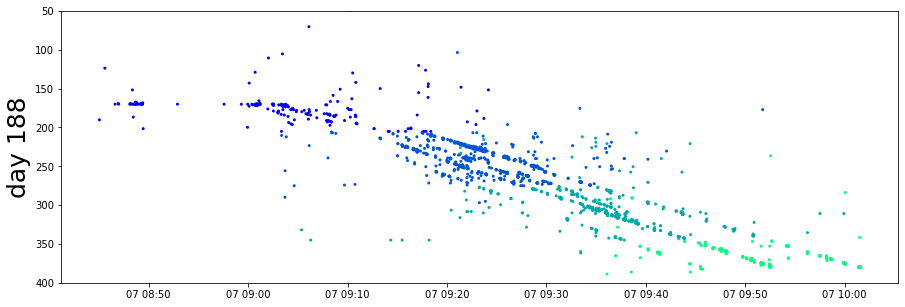

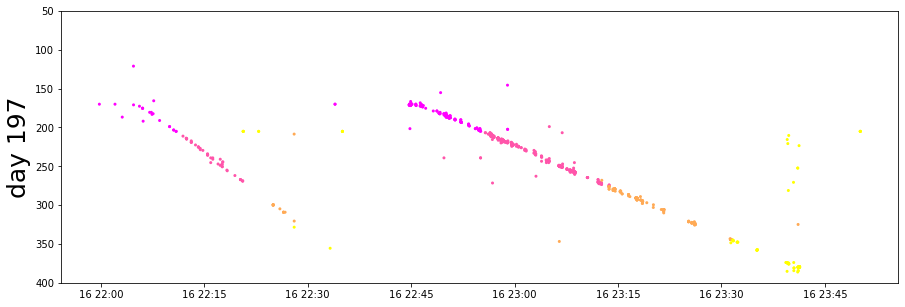

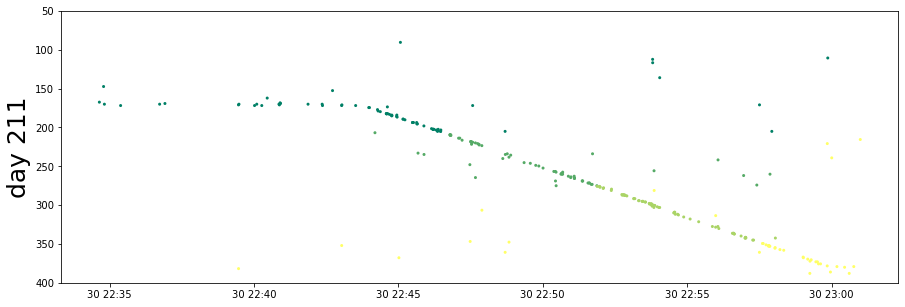

In [22]:
fig, ax = plot_depths(df=df141, cmap='cool', day=141)
fig.savefig('figures/day141_depths.pdf', bbox_inches='tight')

fig, ax = plot_depths(df=df188, cmap='winter', day=188)
fig.savefig('figures/day188_depths.pdf', bbox_inches='tight')

fig, ax = plot_depths(df=df197, cmap='spring', day=197)
fig.savefig('figures/day197_depths.pdf', bbox_inches='tight')

fig, ax = plot_depths(df=df211, cmap='summer', day=211)
fig.savefig('figures/day211_depths.pdf', bbox_inches='tight')


In [23]:
def remove_data_using_linear_model(X, y, removal_factor):
    
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    
    removal_index = np.hstack(
        (np.where(y > predictions + removal_factor*np.std(predictions))
        ,np.where(y < predictions - removal_factor*np.std(predictions)))
    )
    X_new = np.delete(X, removal_index)
    y_new = np.delete(y, removal_index)
    
    return X_new, y_new, model

def convert_matplotlib_numtimes_to_seconds_from_start(times):
    start = dates.num2date(times.min())
    end = dates.num2date(times.max())
    total_seconds = (end - start).total_seconds()

    seconds = np.array([(end - dates.num2date(t[0])).total_seconds() for t in times])
    return total_seconds - seconds

In [24]:
# y = df141.depth.values
# X = (df141.arrival_time).values.reshape(-1, 1)
# X = convert_matplotlib_numtimes_to_seconds_from_start(X)
# X = np.vstack(X)

# fig, ax = plt.subplots(figsize=(15, 5))
# ax.set_ylim(700, -300)

# ax.scatter(X, y, marker='.', color='black')

# xnew = X
# ynew = y
# iteration = 0
# removal_factor = 5
# while True:
#     xold = xnew.reshape(-1, 1)
#     yold = ynew
#     if 'r2' not in locals():
#         r2 = -9999
#         r2_old = r2
#     else:
#         r2_old = r2
#     xnew, ynew, mod = remove_data_using_linear_model(X=xold, y=yold, removal_factor=removal_factor)
#     pred = mod.predict(xold)
#     r2 = r2_score(yold, pred)
#     print('iteration:', iteration , '|'
#           , 'R2 score:', np.round(r2, 6), '+/-', removal_factor, '*', np.std(pred), '|'
#           , 'removed N=', yold.shape[0] - ynew.shape[0], '|'
#           , 'velocity (m/s):', mod.coef_, '|'
#           , 'starting depth(m):', mod.intercept_
#          )
#     ########
#     # plotting nonsense
#     color = plt.cm.jet(iteration/7.5)
#     ax.scatter(xnew, ynew, marker='.', color=color)
#     xline = np.linspace(X.min(), X.max(), 1000)
#     yline = mod.predict(xline.reshape(-1, 1))
#     ax.plot(xline, yline, color=color)
#     #
#     ########
    
#     iteration += 1
#     if r2 > 0.8:
#         break
#     # elif r2_old == r2:
#     elif np.isclose(r2_old, r2, rtol=1e-6):
#         removal_factor = removal_factor - 1.0
#     elif iteration == 1000:
#         break
#     else:
#         pass
    
# # ax.plot(xline, yline, color='red')
# ax.legend(np.arange(iteration), title='iteration')

In [25]:
# mod.intercept_

In [26]:
def do(df):

    y = df.depth.values
    X = (df.arrival_time).values.reshape(-1, 1)
    X = convert_matplotlib_numtimes_to_seconds_from_start(X)
    X = np.vstack(X)

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_ylim(700, -300)

    ax.scatter(X, y, marker='.', color='black')

    xnew = X
    ynew = y
    iteration = 0
    removal_factor = 5
    while True:
        xold = xnew.reshape(-1, 1)
        yold = ynew
        if 'r2' not in locals():
            r2 = -9999
            r2_old = r2
        else:
            r2_old = r2
        xnew, ynew, mod = remove_data_using_linear_model(X=xold, y=yold, removal_factor=removal_factor)
        pred = mod.predict(xold)
        r2 = r2_score(yold, pred)
        print('iteration:', iteration , '|'
              , 'R2 score:', np.round(r2, 6), '+/-', removal_factor, '*', np.std(pred), '|'
              , 'removed N=', yold.shape[0] - ynew.shape[0], '|'
              , 'velocity (m/s):', mod.coef_, '|'
              , 'starting depth:', mod.intercept_
             )
        ########
        # plotting nonsense
        color = plt.cm.jet(iteration/7.5)
        ax.scatter(xnew, ynew, marker='.', color=color)
        xline = np.linspace(X.min(), X.max(), 1000)
        yline = mod.predict(xline.reshape(-1, 1))
        ax.plot(xline, yline, color=color)
        #
        ########

        iteration += 1
        if r2 > 0.8:
            break
        # elif r2_old == r2:
        elif np.isclose(r2_old, r2, rtol=1e-6):
            removal_factor = removal_factor - 1.0
        elif iteration == 1000:
            break
        else:
            pass

    # ax.plot(xline, yline, color='red')
    ax.legend(np.arange(iteration), title='iteration')

iteration: 0 | R2 score: 0.956161 +/- 5 * 64.64479825935891 | removed N= 0 | velocity (m/s): [0.05952873] | starting depth: 165.92633194004526


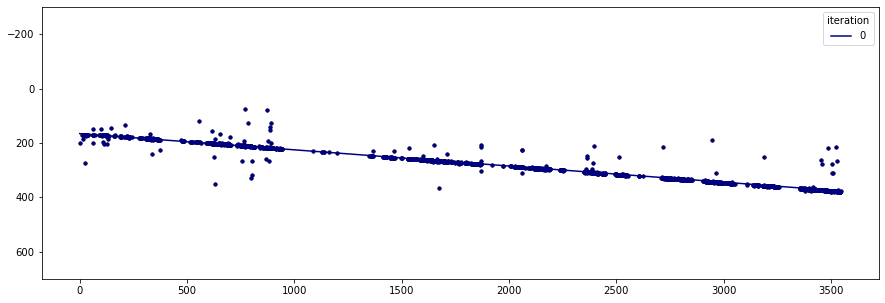

In [27]:
do(df=df141)

iteration: 0 | R2 score: 0.799306 +/- 5 * 52.601813795379314 | removed N= 0 | velocity (m/s): [0.06182356] | starting depth: 108.13341620963939
iteration: 1 | R2 score: 0.799306 +/- 5 * 52.601813795379314 | removed N= 0 | velocity (m/s): [0.06182356] | starting depth: 108.13341620963939
iteration: 2 | R2 score: 0.799306 +/- 4.0 * 52.601813795379314 | removed N= 0 | velocity (m/s): [0.06182356] | starting depth: 108.13341620963939
iteration: 3 | R2 score: 0.799306 +/- 3.0 * 52.601813795379314 | removed N= 3 | velocity (m/s): [0.06182356] | starting depth: 108.13341620963939
iteration: 4 | R2 score: 0.812154 +/- 2.0 * 52.7796046323455 | removed N= 12 | velocity (m/s): [0.06208127] | starting depth: 107.56086495018252


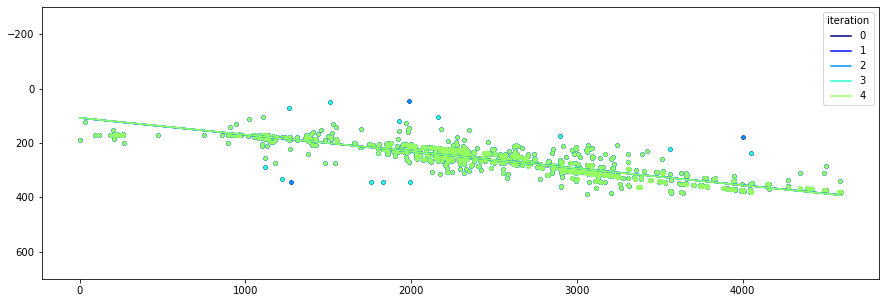

In [28]:
do(df=df188[df188.depth.between(0, 400)])


iteration: 0 | R2 score: 0.820933 +/- 5 * 48.08537729563875 | removed N= 0 | velocity (m/s): [0.05518307] | starting depth: 191.08281918413257


0.05833333333333333

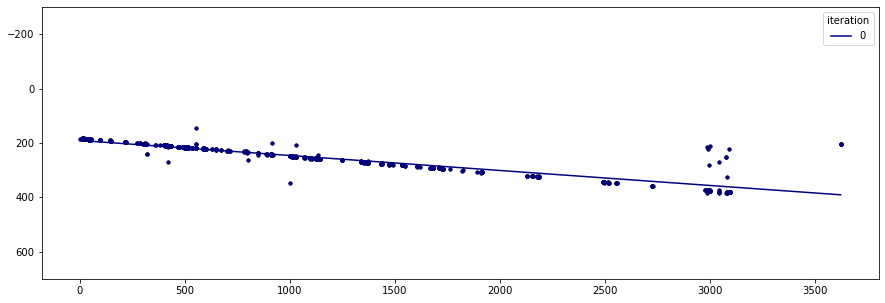

In [29]:
# remove the first event which is small
df = df197[155:]
do(df=df[df.depth.between(0, 400)])
(0.057+0.061+0.057)/3

iteration: 0 | R2 score: 0.535001 +/- 5 * 45.64044375689272 | removed N= 1 | velocity (m/s): [0.16571519] | starting depth: 198.97724513600966
iteration: 1 | R2 score: 0.591832 +/- 5 * 47.33840178801068 | removed N= 0 | velocity (m/s): [0.17260727] | starting depth: 197.0299830351795
iteration: 2 | R2 score: 0.591832 +/- 5 * 47.33840178801068 | removed N= 0 | velocity (m/s): [0.17260727] | starting depth: 197.0299830351795
iteration: 3 | R2 score: 0.591832 +/- 4.0 * 47.33840178801068 | removed N= 0 | velocity (m/s): [0.17260727] | starting depth: 197.0299830351795
iteration: 4 | R2 score: 0.591832 +/- 3.0 * 47.33840178801068 | removed N= 6 | velocity (m/s): [0.17260727] | starting depth: 197.0299830351795
iteration: 5 | R2 score: 0.775841 +/- 2.0 * 51.65750338901267 | removed N= 7 | velocity (m/s): [0.18926224] | starting depth: 192.81457304120732
iteration: 6 | R2 score: 0.927726 +/- 2.0 * 54.924598194800296 | removed N= 0 | velocity (m/s): [0.20383818] | starting depth: 187.175692540

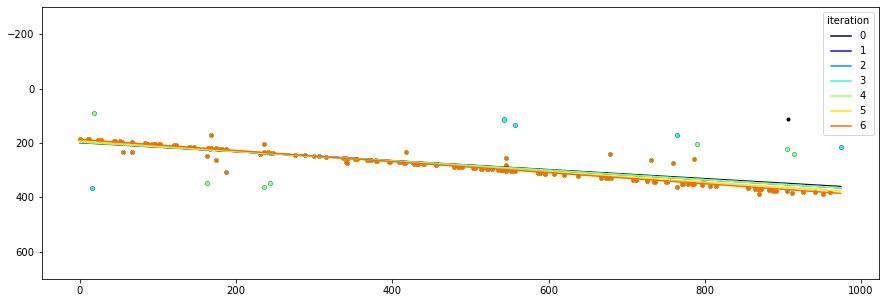

In [30]:
# remove first few events which make fitline nonlinear
df = df211[40:]
do(df=df[df.depth.between(0, 400)])

<AxesSubplot:xlabel='arrival_datetime'>

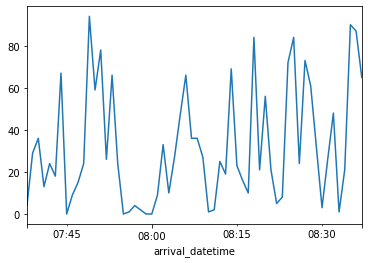

In [31]:
df141.groupby(pd.Grouper(key = 'arrival_datetime', freq='1min')).count().id.plot()

In [32]:
times = df141.arrival_datetime.diff().apply(lambda t: t.total_seconds()).values
times = times[1:].cumsum()
X = np.vstack([times
,df141.depth.values[1:]]).transpose()

array([[  10.204,  170.   ],
       [  13.384,  184.   ],
       [  13.839,  170.875],
       ...,
       [3543.79 ,  380.   ],
       [3544.744,  379.125],
       [3545.596,  377.375]])

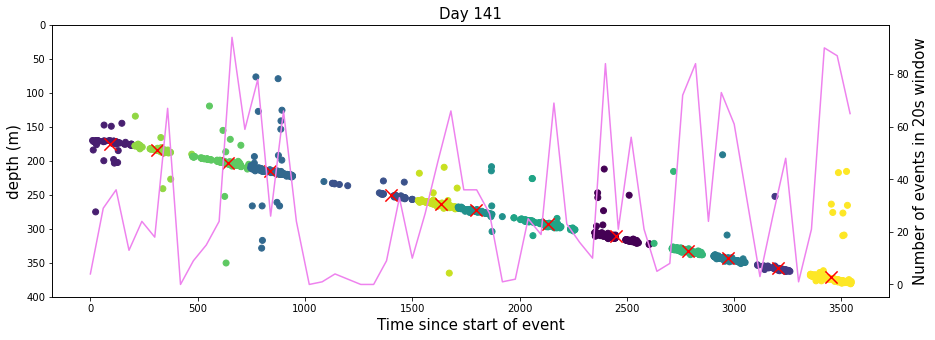

In [33]:
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

data = df141.copy()

# Generate some random data with two variables (x and y)
# np.random.seed(42)
times = data.arrival_datetime.diff().apply(lambda t: t.total_seconds()).values
times = times[1:].cumsum()
X = np.vstack([times
,data.depth.values[1:]]).transpose()

# Fit KMeans clustering model with two clusters
kmeans = KMeans(n_clusters=13).fit(X)

# Get cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Plot data points with different colors for each cluster
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(X[:, 0], X[:, 1], c=labels)
# Plot centroids with black color and larger marker size
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=150, color='red')
ax.set_ylim(400, 0)
kmeans.inertia_
ax.set_ylabel('depth (m)', fontsize=15)
ax.set_xlabel('Time since start of event', fontsize=15)

ax2 = ax.twinx()
window = data.groupby(pd.Grouper(key = 'arrival_datetime', freq='1min')).count().id#.plot(ax=ax2)
window_t = window.index.to_series().diff().apply(lambda t: t.total_seconds())
x = window_t.fillna(0).cumsum().values
y = window.values
ax2.plot(x, y, color='violet')
ax2.set_ylabel('Number of events in 20s window', fontsize=15)

ax.set_title('Day 141', fontsize=15)
X

In [34]:
print('mean recurrence interval:', pd.Series(sorted(centroids[:,0])).diff().mean())

mean recurrence interval: 279.7841698331766


In [208]:
def make_tn(df):
    df = df.copy().arrival_datetime.drop_duplicates()
    tn = df.values
    # time since last event
    ts = []
    # time until next event
    tu = []
    for n, t in enumerate(tn):
        # we use a try/except block to take care of the 
        # failure when looking before the array starts
        # and after the array ends
        try:
            tn_minus1 = tn[n-1]
            tn_plus1 = tn[n+1]
            ts.append(t - tn_minus1)
            tu.append(tn_plus1 - t)
        except:
            pass
    
    tndf = pd.DataFrame(
        {
            'tn-1':ts
            ,'tn':tn[1:]
            ,'tn+1':tu
        }
        ,index=df[1:].index
    )
    tndf['tn-1'] = tndf['tn-1'].apply(lambda t: t.total_seconds())
    tndf['tn+1'] = tndf['tn+1'].apply(lambda t: t.total_seconds())
    return tndf

number of total events: (4438, 3)


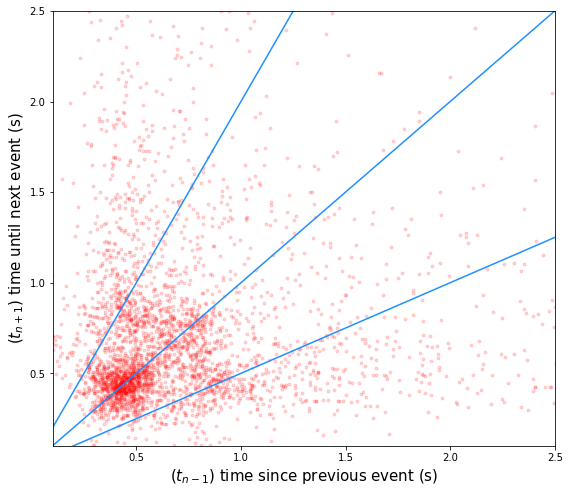

In [336]:
tndf = pd.concat(
    [
     make_tn(df141)
    ,make_tn(df188)
    ,make_tn(df197)
    ,make_tn(df211)
    ]
)

print('number of total events:', tndf.shape)
fig, ax = plt.subplots(figsize=(9, 8))
ax.scatter(x=tndf['tn-1'], y=tndf['tn+1'], marker='.', color='red', alpha=0.15)
# ax.plot(tndf['tn-1'], tndf['tn+1'], marker='.', color='red', alpha=0.15)
# ax.plot(tndf['tn-1'], tndf['tn+1'], marker='.', cmap='nipy_spectral', c=tndf.index.values/4438, alpha=0.15)
ax.set_xlim(0.1, 2.5)
ax.set_ylim(0.1, 2.5)
ax.set_xlabel(r'$(t_{n-1})$ time since previous event (s)', fontsize=15)
ax.set_ylabel(r'$(t_{n+1})$ time until next event (s)', fontsize=15)

x = np.linspace(0, 5, 100)
y = x
ax.plot(x, y, color='dodgerblue')
y = 2*x
ax.plot(x, y, color='dodgerblue')
y = 0.5*x
ax.plot(x, y, color='dodgerblue')

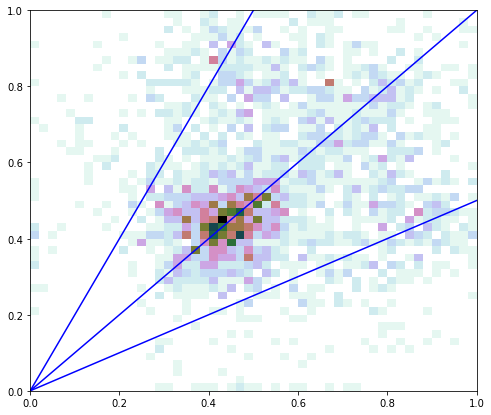

In [328]:
xy = tndf[(tndf['tn-1']>0) & (tndf['tn+1']>0)][['tn-1', 'tn+1']].copy()

fig, ax = plt.subplots(figsize=(8, 7))

ax.hist2d(x=xy['tn-1'].values, y=xy['tn+1'].values, range=[[0, 1], [0, 1]], bins=50
         ,cmap='cubehelix_r')
x = np.linspace(0, 5, 100)
y = x
ax.plot(x, y, color='blue')
y = 2*x
ax.plot(x, y, color='blue')
y = 0.5*x
ax.plot(x, y, color='blue')

<AxesSubplot:>

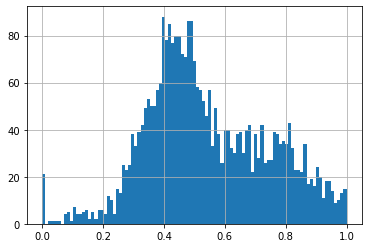

In [210]:
tndf['tn-1'].hist(bins=np.linspace(0, 1, 100))

<AxesSubplot:>

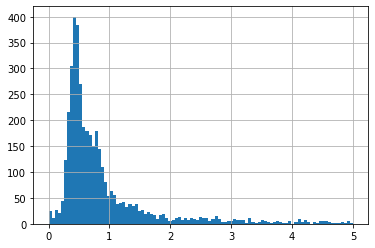

In [211]:
tndf['tn+1'].hist(bins=np.linspace(0, 5, 100))

In [212]:
tndf[tndf['tn-1'].between(-0.001, 0.001)]

,tn-1,tn,tn+1
1956,0.001000,2019-07-07 09:34:17.012999,0.375000
1977,-0.000001,2019-07-07 09:34:34.808999,0.720000
2041,0.001000,2019-07-07 09:35:54.910999,0.408000
2122,0.000001,2019-07-07 09:36:56.828999,0.335999
2132,-0.000001,2019-07-07 09:37:03.217998,0.358999
2137,0.001000,2019-07-07 09:37:05.562000,0.817001
2473,0.000999,2019-07-07 09:37:53.357999,0.550000
2216,0.000001,2019-07-07 09:38:38.865999,3.293999
2248,-0.000001,2019-07-07 09:39:14.367999,2.034000
2251,-0.000001,2019-07-07 09:39:24.698999,9.642000


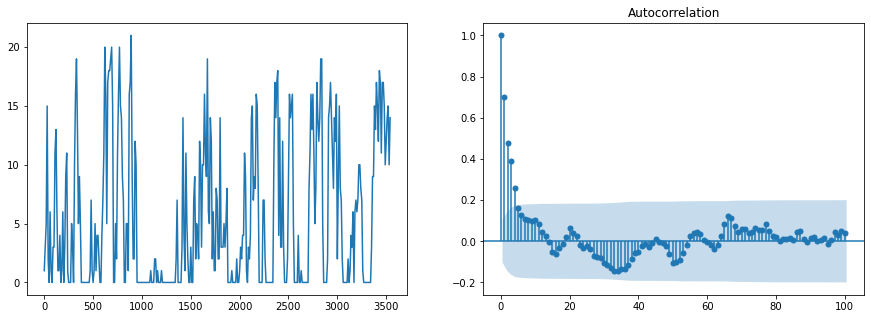

In [298]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

ts = df141.groupby(pd.Grouper(key = 'arrival_datetime', freq='10s')).count().id
ts_cnt = ts.values
ts_dt = ts.index
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.arange(1, ts_dt.shape[0]*10, 10), ts_cnt)
fig = tsaplots.plot_acf(ts_cnt, lags=100, ax=ax[1])

array([   1,   31,   61,   91,  121,  151,  181,  211,  241,  271,  301,
        331,  361,  391,  421,  451,  481,  511,  541,  571,  601,  631,
        661,  691,  721,  751,  781,  811,  841,  871,  901,  931,  961,
        991, 1021, 1051, 1081, 1111, 1141, 1171, 1201, 1231, 1261, 1291,
       1321, 1351, 1381, 1411, 1441, 1471, 1501, 1531, 1561, 1591, 1621,
       1651, 1681, 1711, 1741, 1771, 1801, 1831, 1861, 1891, 1921, 1951,
       1981, 2011, 2041, 2071, 2101, 2131, 2161, 2191, 2221, 2251, 2281,
       2311, 2341, 2371, 2401, 2431, 2461, 2491, 2521, 2551, 2581, 2611,
       2641, 2671, 2701, 2731, 2761, 2791, 2821, 2851, 2881, 2911, 2941,
       2971, 3001, 3031, 3061, 3091, 3121, 3151, 3181, 3211, 3241, 3271,
       3301, 3331, 3361, 3391, 3421, 3451, 3481, 3511, 3541])

Text(0, 0.5, 'time until next event (s)')

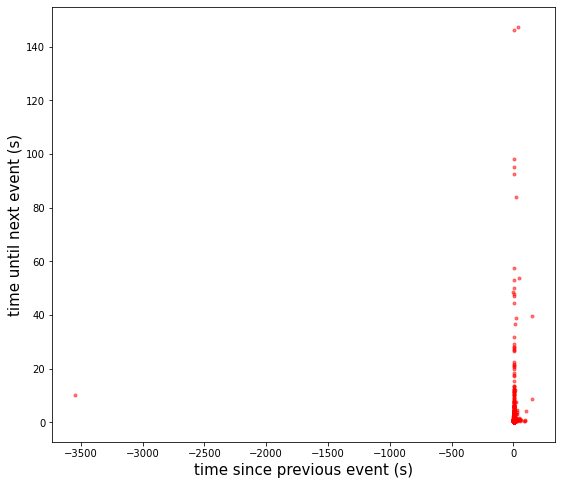

In [164]:
# tndf = make_tn(df141)

# fig, ax = plt.subplots(figsize=(9, 8))
# ax.scatter(x=tndf['tn-1'], y=tndf['tn+1'], marker='.', color='red', alpha=0.5)
# # ax.set_xlim(0, 2)
# # ax.set_ylim(0, 2)
# ax.set_xlabel('time since previous event (s)', fontsize=15)
# ax.set_ylabel('time until next event (s)', fontsize=15)

Text(0, 0.5, 'time until next event (s)')

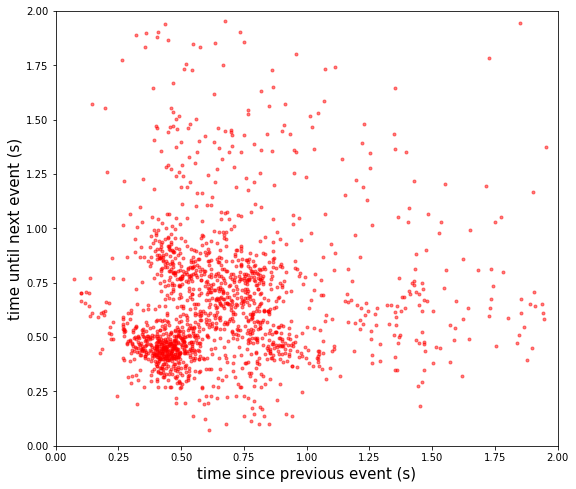

In [151]:
# tn = df141.arrival_datetime.values

# time_since_last_event = []
# time_until_next_event = []

# for n, t in enumerate(tn):
#     try:
#         # print(tn[n-1], t, tn[n+1])
#         tn_minus1 = tn[n-1]
#         tn_plus1 = tn[n+1]
#         time_since_last_event.append(t - tn_minus1)
#         time_until_next_event.append(tn_plus1 - t)
#     except:
#         pass
    
# # ax.scatter(time_since_last_event, time_until_next_event)
# tndf = pd.DataFrame({'tn-1':time_since_last_event
#               ,'t':tn[1:]
#               ,'tn+1':time_until_next_event
#              })
# tndf['tn-1'] = tndf['tn-1'].apply(lambda t: t.total_seconds())
# tndf['tn+1'] = tndf['tn+1'].apply(lambda t: t.total_seconds())

# fig, ax = plt.subplots(figsize=(9, 8))
# ax.scatter(x=tndf['tn-1'], y=tndf['tn+1'], marker='.', color='red', alpha=0.5)
# ax.set_xlim(0, 2)
# ax.set_ylim(0, 2)
# ax.set_xlabel('time since previous event (s)', fontsize=15)
# ax.set_ylabel('time until next event (s)', fontsize=15)

In [ ]:
(tndf['tn'] - tndf['tn+1']).apply(lambda t: t.total_seconds())

In [111]:
x = np.array([1, 2, 3])
np.append(x, 4)
np.concatenate([[0], x])
np.concatenate([tn[1:], [np.datetime64('1970')]])
# np.concatn[1:]

array(['2019-05-21T07:38:53.972000000', '2019-05-21T07:38:57.152000000',
       '2019-05-21T07:38:57.607000000', ...,
       '2019-05-21T08:37:48.512000000', '2019-05-21T08:37:49.364000000',
       '1970-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [35]:
# # from sklearn.cluster import KMeans, DBSCAN
# # import matplotlib.pyplot as plt

# data = df141.copy()

# # Generate some random data with two variables (x and y)
# # np.random.seed(42)
# times = data.arrival_datetime.diff().apply(lambda t: t.total_seconds()).values
# times = times[1:].cumsum()
# X = np.vstack([times
# ,data.depth.values[1:]]).transpose()

# centroids = []
# for n in np.arange(0, 100, 1):

# # Fit KMeans clustering model with two clusters
#     kmeans = KMeans(n_clusters=13).fit(X)

# # Get cluster labels and centroids
#     labels = kmeans.labels_
#     centroid = kmeans.cluster_centers_
#     centroids.append(centroid)
    


# # # Plot data points with different colors for each cluster
# # fig, ax = plt.subplots(figsize=(15, 5))
# # ax.scatter(X[:, 0], X[:, 1], c=labels)
# # # Plot centroids with black color and larger marker size
# # ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=150, color='red')
# # ax.set_ylim(400, 0)
# # kmeans.inertia_
# # ax.set_ylabel('depth (m)', fontsize=15)
# # ax.set_xlabel('Time since start of event', fontsize=15)

# # ax2 = ax.twinx()
# # window = data.groupby(pd.Grouper(key = 'arrival_datetime', freq='1min')).count().id#.plot(ax=ax2)
# # window_t = window.index.to_series().diff().apply(lambda t: t.total_seconds())
# # x = window_t.fillna(0).cumsum().values
# # y = window.values
# # ax2.plot(x, y, color='violet')
# # ax2.set_ylabel('Number of events in 20s window', fontsize=15)

# # ax.set_title('Day 141', fontsize=15)

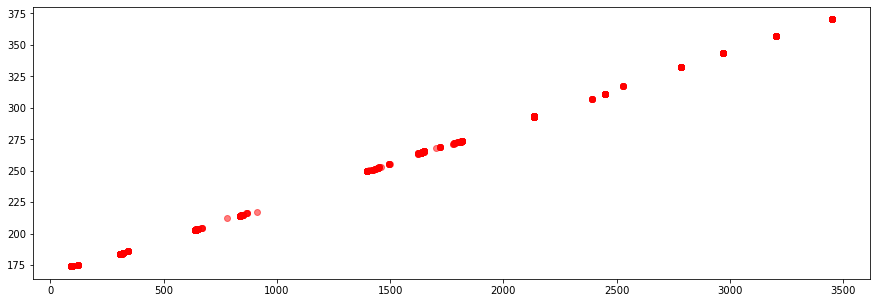

In [36]:
# fig, ax = plt.subplots(figsize=(15, 5))

# for run in centroids:
#     ax.scatter(run[:,0], run[:,1], color='red', alpha=0.5)

arrival_datetime
2019-05-21 07:38:40+00:00    181.593750
2019-05-21 07:39:00+00:00    176.343750
2019-05-21 07:39:20+00:00    170.875000
2019-05-21 07:39:40+00:00    171.750000
2019-05-21 07:40:00+00:00    170.583333
                                ...    
2019-05-21 08:36:20+00:00    371.661765
2019-05-21 08:36:40+00:00    369.570000
2019-05-21 08:37:00+00:00    368.355769
2019-05-21 08:37:20+00:00    367.050000
2019-05-21 08:37:40+00:00    379.187500
Freq: 20S, Name: depth, Length: 178, dtype: float64

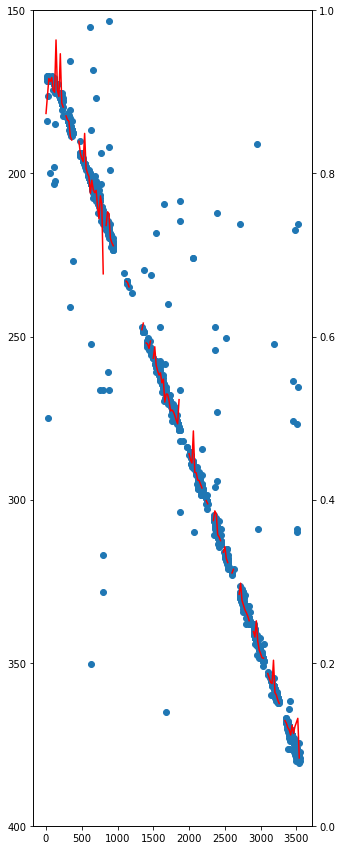

In [254]:
# from sklearn.cluster import KMeans, DBSCAN
# import matplotlib.pyplot as plt

# data = df141.copy()

# # Generate some random data with two variables (x and y)
# # np.random.seed(42)
# times = data.arrival_datetime.diff().apply(lambda t: t.total_seconds()).values
# times = times[1:].cumsum()

# X = np.vstack([times, data.depth.values[1:]
#               ]).transpose()

# fig, ax = plt.subplots(figsize=(5, 15))
# ax.scatter(X[:,0], X[:,1])
# ax.set_ylim(400, 150)

# # roll = pd.DataFrame(X, columns=['time', 'depth']).groupby(pd.Grouper(key = 'time', freq='1min')).count()
# # ax.plot(roll.time, roll.depth, color='red')
# y = df141.groupby(pd.Grouper(key='arrival_datetime', freq='20s')).mean().depth
# x = y.index.to_series().diff().apply(lambda t: t.total_seconds()).fillna(0).cumsum().values

# # x = y.index.to_series().diff().apply(lambda t: t.total_seconds())
# # x = np.arange(0, y.shape[0], 20)
# ax2 = ax.twinx()
# ax.ploat(x, y.values, color='red')
# y

In [216]:
# X

array([[ 170.   ,   10.204],
       [ 184.   ,   13.384],
       [ 170.875,   13.839],
       ...,
       [ 380.   , 3543.79 ],
       [ 379.125, 3544.744],
       [ 377.375, 3545.596]])

In [26]:
# df141.columns

Index(['Unnamed: 0', 'id', 'depth', 'relative_depth', 'radius', 'aic_t',
       'aics', 'aic_maxes', 'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt', 'parrival',
       'max_amp', 'cum_amp', 'arrival_datetime'],
      dtype='object')

In [27]:
# df141['better_radius'] = np.sqrt(4500**2 * df141.dt.values**2 - df141.relative_depth.values**2)


/tmp/ipykernel_15974/2760798133.py:1: RuntimeWarning: invalid value encountered in sqrt
  df141['better_radius'] = np.sqrt(4500**2 * df141.dt.values**2 - df141.relative_depth.values**2)


<AxesSubplot:>

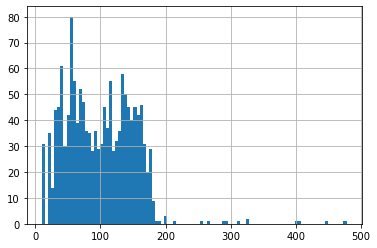

In [28]:
# df141.better_radius.hist(bins=100)

(<Figure size 1080x360 with 2 Axes>,
 <AxesSubplot:xlabel='time ---->', ylabel='radius (m)'>)

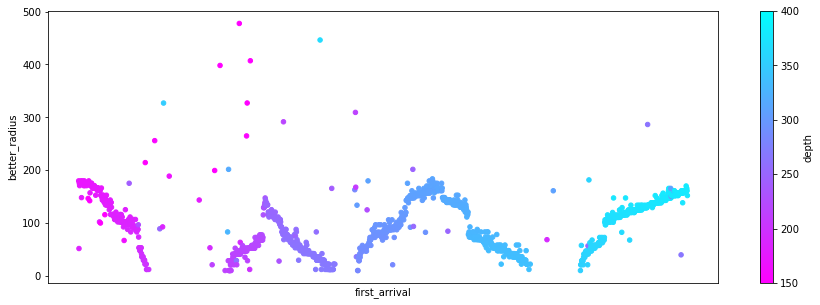

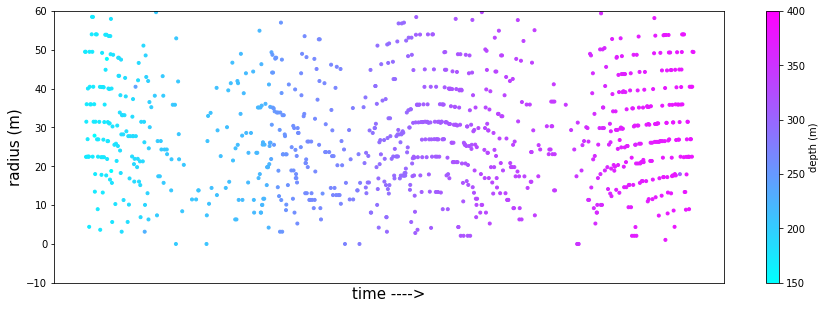

In [29]:
# fig, ax = plt.subplots(figsize=(15, 5))
# cbar = df141.plot.scatter(x='first_arrival', y='better_radius', ax=ax, c='depth', cmap='cool_r', vmin=150, vmax=400)
# ax.set_xticks([])
# plot_radius(df=df141, cmap='cool', day=141)


(<Figure size 1080x360 with 2 Axes>,
 <AxesSubplot:xlabel='time ---->', ylabel='radius (m)'>)

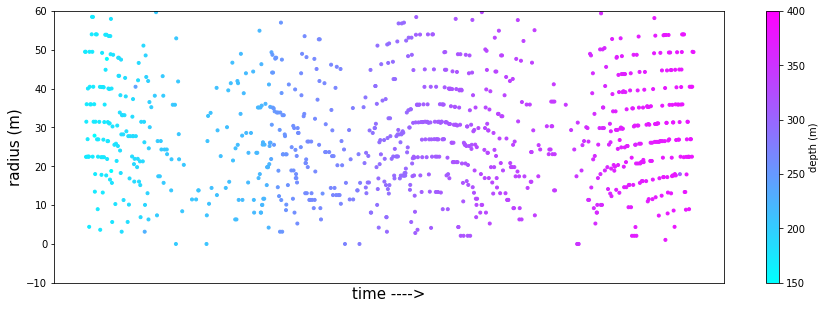

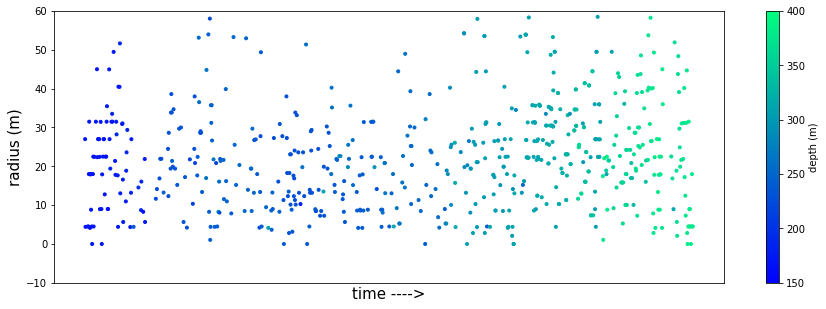

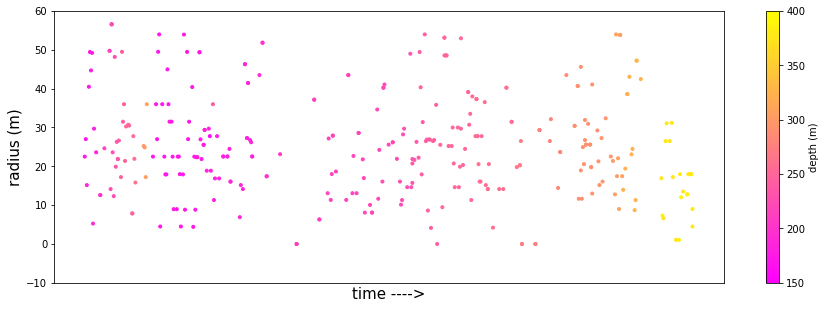

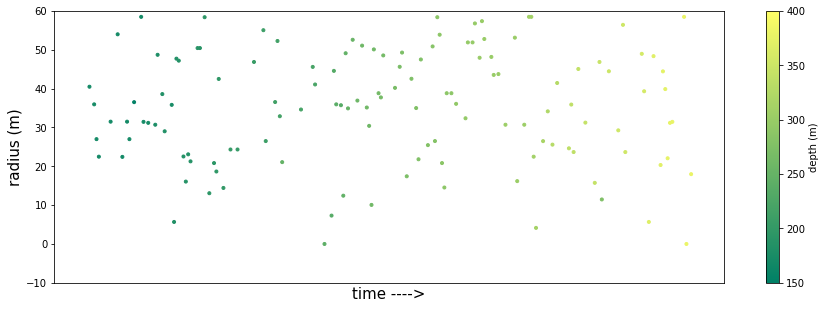

In [30]:
# plot_radius(df=df141, cmap='cool', day=141)
# plot_radius(df=df188, cmap='winter', day=188)
# plot_radius(df=df197, cmap='spring', day=197)
# plot_radius(df=df211, cmap='summer', day=211)

<AxesSubplot:xlabel='depth', ylabel='radius'>

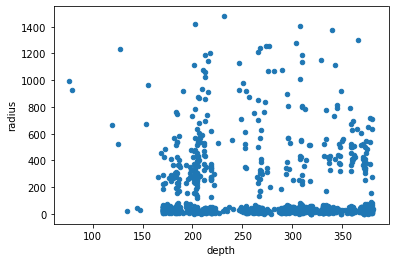

In [31]:
# df141.plot.scatter(x='depth', y='radius')

<AxesSubplot:>

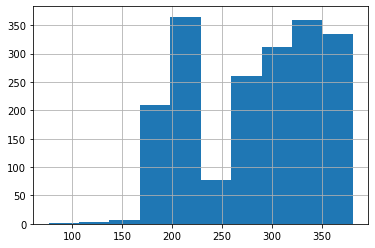

In [32]:
# df141.depth.hist()

In [33]:
# df141.columns

Index(['Unnamed: 0', 'id', 'depth', 'relative_depth', 'radius', 'aic_t',
       'aics', 'aic_maxes', 'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt', 'parrival',
       'max_amp', 'cum_amp', 'arrival_datetime', 'better_radius'],
      dtype='object')

In [34]:
# df141[['depth', 'radius', 'first_hydrophone', 'second_hydrophone']].corr()

,depth,radius,first_hydrophone,second_hydrophone
depth,1.000000,-0.155037,0.944502,0.650003
radius,-0.155037,1.000000,-0.096705,-0.182130
first_hydrophone,0.944502,-0.096705,1.000000,0.446501
second_hydrophone,0.650003,-0.182130,0.446501,1.000000


<AxesSubplot:>

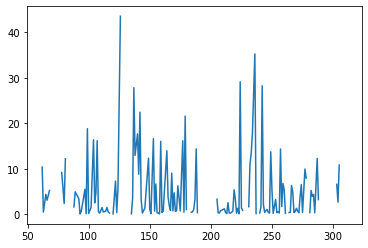

In [35]:
# df141['first_arrival'] = df.first_arrival.apply(pd.to_datetime)
# df141['diff'] = df141.first_arrival.diff().apply(lambda t: t.total_seconds())

# df141['diff'].plot()

<AxesSubplot:>

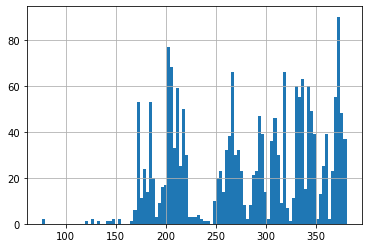

In [36]:
# df141.depth.hist(bins=100)

In [38]:
def make_time_interval_plots(df):
    df = df.copy().sort_values(by='first_arrival')
    
    df['first_arrival'] = df.first_arrival.apply(pd.to_datetime)
    df['diff'] = df.first_arrival.diff().apply(lambda t: t.total_seconds())
    df.set_index('first_arrival', inplace=True)
    
    fig, ax = plt.subplots()
    df['diff'].plot(ax=ax)
    
    fig, ax = plt.subplots()
    df['diff'].hist(bins=np.linspace(0, 20, 100), log=True, ax=ax)

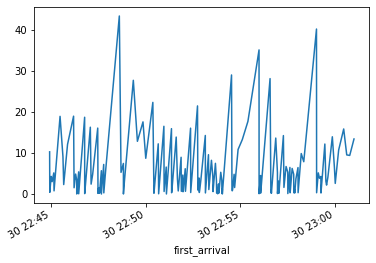

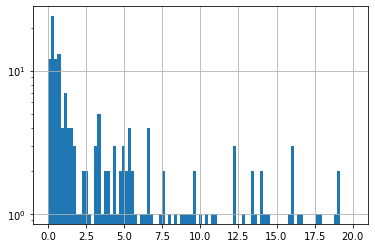

In [39]:
# make_time_interval_plots(df=df141)

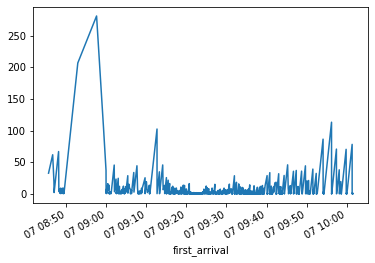

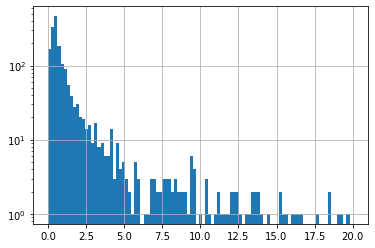

In [40]:
# make_time_interval_plots(df=df188)

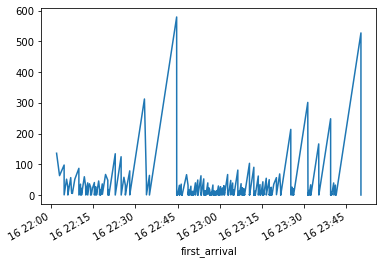

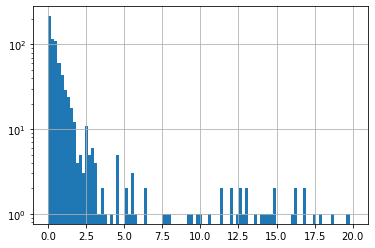

In [41]:
# make_time_interval_plots(df=df197)

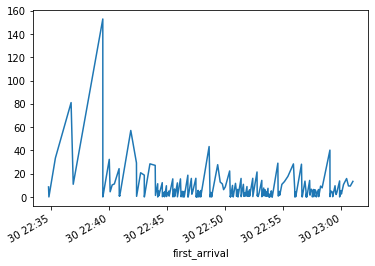

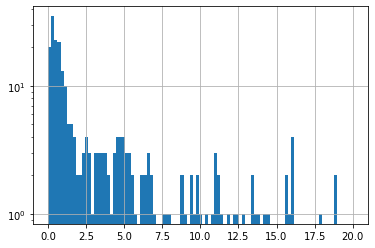

In [42]:
# make_time_interval_plots(df=df211)

In [43]:
# # what if its at the borehole wall?
# import config
# config.hydrophone_metadata_141['h3']

{'start': 2019-05-21T07:35:00.000000Z,
 'end': 2019-05-21T07:48:00.000000Z,
 'depth': 170,
 'velocity_model': 1750}

In [44]:
# df141.first_hydrophone.unique()

array([2, 3, 4, 5])

In [45]:
phone_depths = []
for first_phone in df141.first_hydrophone.values:
    phone_id = 'h'+str(first_phone+1)
    dh = config.hydrophone_metadata_141[phone_id]['depth']
    phone_depths.append(dh)
    
df141['first_phone_depth'] = phone_depths

In [46]:
wall_velocities = (df141.first_phone_depth - df141.depth)/(pd.to_datetime(df141.first_arrival) - pd.to_datetime(df141.parrival)).apply(lambda t: t.total_seconds())

In [47]:
wall_velocities.replace([np.inf, -np.inf], np.nan, inplace=True)


<AxesSubplot:>

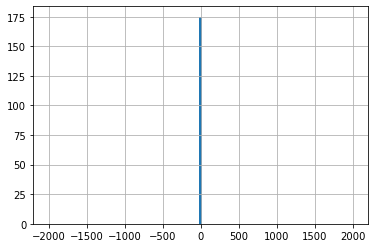

In [48]:
wall_velocities.abs().hist(bins=np.linspace(-2000, 2000, 100))

<AxesSubplot:>

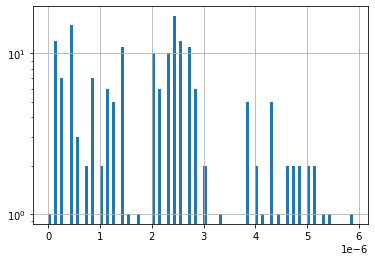

In [49]:
wall_velocities.abs().hist(bins=100, log=True)

In [50]:
wall_velocities.abs().mean()

2.065501675494866e-06

In [51]:
wall_velocities.abs().std()

1.3963153989302989e-06

<AxesSubplot:>

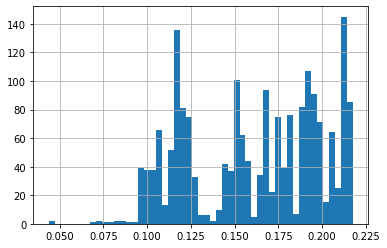

In [52]:
# (df141.depth/1750
# ).hist(bins=51)

In [53]:
# (df141.depth/6800).mean()

0.04164557757333901

<AxesSubplot:>

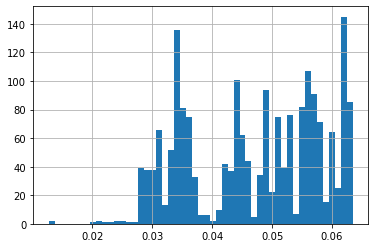

In [54]:
# (df141.depth/6000).hist(bins=51)

In [55]:
# df141.iloc[750]

# velocity = 
# # [rows, cols]
# dist_from_borehole = np.zeros([240-170, 51])
# # for i in np.arange(dist_from_borehole.shape[0]):
# for row in np.arange(dist_from_borehole.shape[0]):
#     for col in np.arange(dist_from_borehole.shape[1]):
        

In [56]:
# dist_from_borehole.shape

In [57]:
# config.hydrophone_metadata_141['h3']

In [58]:
# config.hydrophone_metadata_141['h4']